In [66]:
#Importando as bibliotecas
import numpy as np
from scipy import stats
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [67]:
# Importando os dados e os explorando
df, units = ingest_data('C:/Users/Rafael/Desktop/Cientista de Dados JR - Desafio NASA/SolarPrediction.csv')
print(df.head())

                           Radiation  Temperature  Pressure  Humidity  \
UNIXTime                                                                
2016-09-01 00:00:08-10:00       2.58         51.0     30.43       103   
2016-09-01 00:05:10-10:00       2.83         51.0     30.43       103   
2016-09-01 00:20:06-10:00       2.16         51.0     30.43       103   
2016-09-01 00:25:05-10:00       2.21         51.0     30.43       103   
2016-09-01 00:30:09-10:00       2.25         51.0     30.43       103   

                           WindDirection  WindSpeed  DayLength  
UNIXTime                                                        
2016-09-01 00:00:08-10:00          77.27      11.25    45060.0  
2016-09-01 00:05:10-10:00         153.44       9.00    45060.0  
2016-09-01 00:20:06-10:00         142.04       7.87    45060.0  
2016-09-01 00:25:05-10:00         144.12      18.00    45060.0  
2016-09-01 00:30:09-10:00          67.42      11.25    45060.0  


In [ ]:
# Primeiramente é criado uma matriz de correlação, para eliminar dados irrelevantes e identificar os recursos mais 
# significativos do conjunto de dados.

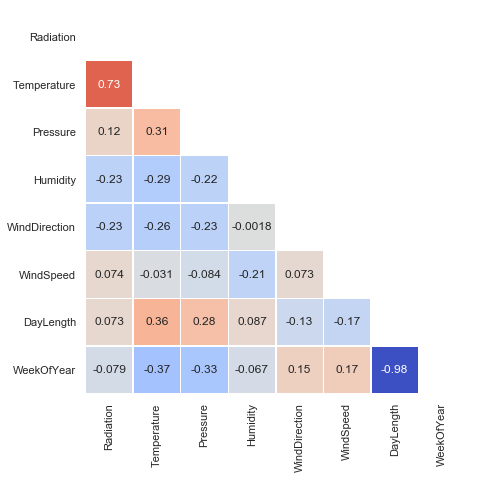

In [68]:
sns.set(style="white")

def corrPairs(df):
    '''Pairwise correlation matrix'''
    corr = df.corr() # Calcular a matriz de correlação
    mask = np.zeros_like(corr, dtype=np.bool) # make mask
    mask[np.triu_indices_from(mask)] = True # mask upper triangle
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5, annot=True, cbar=False)

df['WeekOfYear'] = df.index.week # Adicionar semana para ver a correlação
plt.figure(figsize=(7,7))
corrPairs(df)

In [ ]:
# Podemos identificar que existe uma forte corelação entre a Radiação e a Temperatura (o que já era esperado).

C:\Users\Rafael\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


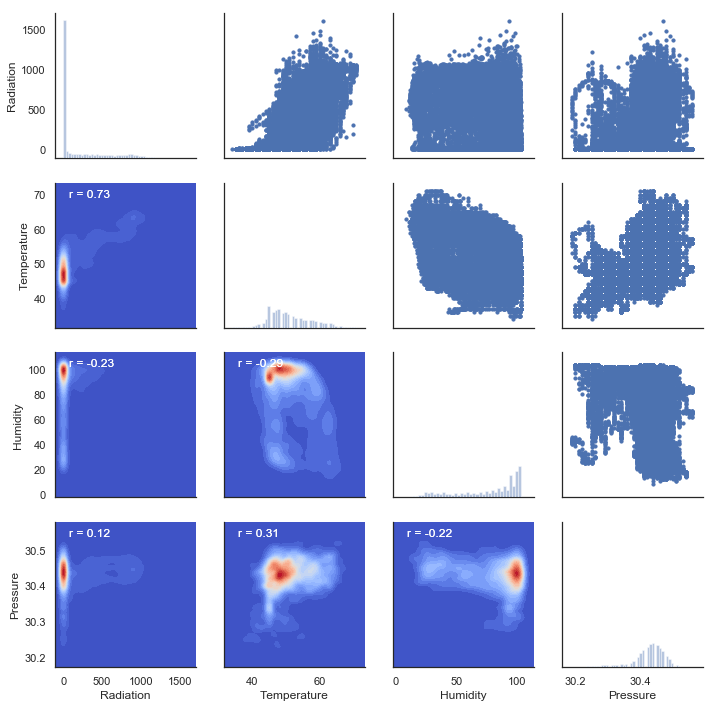

In [69]:
def corrfunc(x, y, **kws):
    '''add pearsonr correlatioin to plots'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),xy=(.1, .9), xycoords=ax.transAxes, color='white')
    return

def corrMap(df,features):
    '''plot bivariate correlations'''
    g = sns.PairGrid(df, vars=features)
    g.map_upper(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False)
    g.map_lower(sns.kdeplot, cmap="coolwarm", shade=True, n_levels=30)
    g.map_lower(corrfunc)
    g.map_lower(corrfunc)
    
    
feature_list=['Radiation','Temperature','Humidity','Pressure']
# bivariate density matrix
corrMap(df,feature_list)
plt.show()

In [ ]:
# Observando as correlações de uma outra forma observamos a alta taxa de correlação entre a Radiação e a Temperatura.
# É esperado que a Radiação varie com as mudanças climaticas sazonais, porem o conjunto de dados contem apenas os dados
# de outono a inverno, sendo assim o algoritimo pode ser menos capaz de realizar uma predição da radiação para o verão.

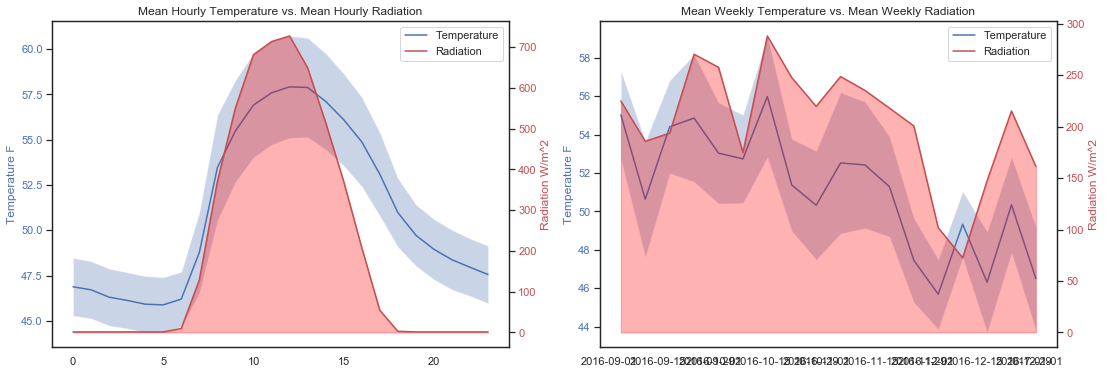

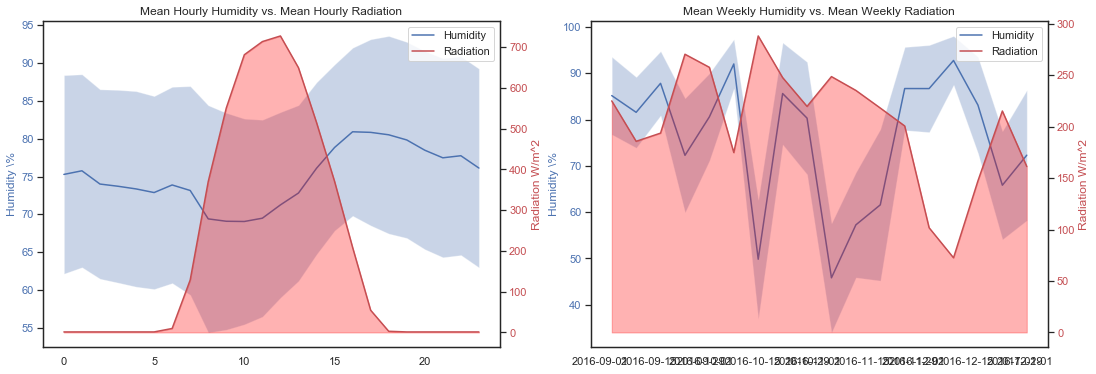

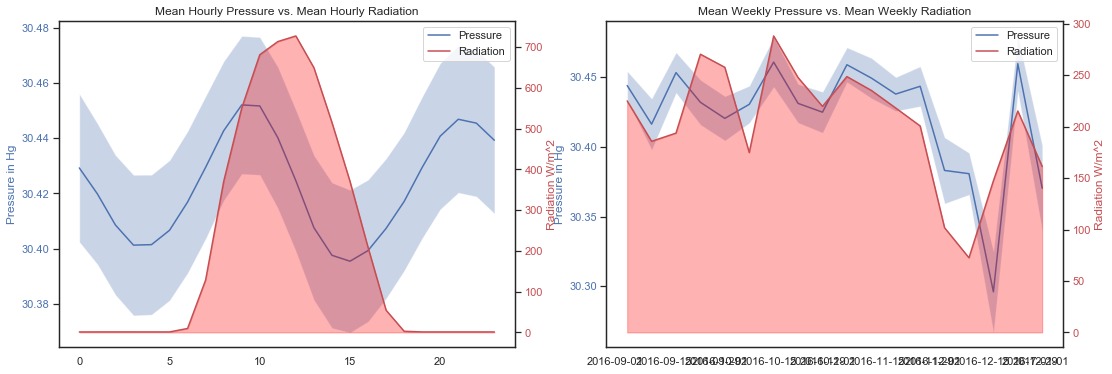

In [61]:
def color_y_axis(ax, color):
    '''Color y axis on two-axis plots'''
    for t in ax.get_yticklabels():
        t.set_color(color)
    ax.yaxis.label.set_color(color)
    return None

def plotVs(df,timescale,feature1,feature2,ax1,units):
    '''Plot feature vs radiation'''
    ax2=ax1.twinx()
    df_grouped= df.groupby(timescale)

    df_feature1 = df_grouped[feature1].mean()
    df_feature1_errorpos =  df_feature1+df_grouped[feature1].std()/2
    df_feature1_errorneg =  df_feature1-df_grouped[feature1].std()/2
    ax1.plot(df_feature1)
    ax1.fill_between(df_feature1.index, df_feature1_errorpos.values, df_feature1_errorneg.values, alpha=0.3, antialiased=True)
    ax1.set_ylabel(feature1+' '+units[feature1])
    color_y_axis(ax1, 'b')

    if feature2 == 'Radiation':
        rad = df_grouped['Radiation'].mean()
        ax2.plot(rad,'r')
        ax2.fill_between(df_feature1.index, 0, rad, alpha=0.3, antialiased=True, color='red')
        ax2.set_ylabel('Radiation'+' '+units['Radiation'])
        color_y_axis(ax2, 'r')
    else:
        df_feature2 = df_grouped[feature2].mean()
        df_feature2_errorpos =  df_feature2+df_grouped[feature2].std()/2
        df_feature2_errorneg =  df_feature2-df_grouped[feature2].std()/2
        ax1.plot(df_feature2)
        ax1.fill_between(df_feature2.index, df_feature2_errorpos.values, df_feature2_errorneg.values, alpha=0.3, antialiased=True)
        ax1.set_ylabel(feature2+' '+units[feature2])
        color_y_axis(ax1, 'g')
    return ax1, ax2

def HourlyWeeklyVs(df,feature1,feature2,units):
    '''Plot a feature vs radiation for time of day and week of year'''
    plt.figure(figsize=(18, 6))
    ax=plt.subplot(121) # hourly
    ax1,ax2 = plotVs(df,df.index.hour,feature1,feature2,ax,units)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    plt.xlabel('Hour of Day (Local Time)')
    plt.title('Mean Hourly {0} vs. Mean Hourly {1}'.format(feature1,feature2))

    ax=plt.subplot(122) # weekly
    ax1, ax2 = plotVs(df,pd.Grouper(freq='W'),feature1,feature2,ax,units)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    plt.xlabel('Week of Year')
    plt.title('Mean Weekly {0} vs. Mean Weekly {1}'.format(feature1,feature2))
    return

for feature in feature_list[1:]: # radiation vs feature
    HourlyWeeklyVs(df,feature,feature_list[0],units)
plt.show()

In [62]:
# A partir da análse exploratória até aqui, podemos observar os seguintes padrãoes no conjunto de dados:

# - Temperaturas mais altas correlacionam - se com uma maior radiação. Isso é confirmado com um R de Pearson de 0,73.
#   Observe que a temperatura acompanha o comportamento da Radiação tanto na escala diaria quanto a semanal.

# - A Umidade tem um impacto menor, mas significativo na Radiação, com um R de 0,20.

# - A Pressão não se correlaciona com a Radiação, mas se correlaciona com a Temperatura e a Umidade. Esses três dados
#   compõem o que chamamos de Clima e estão diretamente interligados no fenomenos atmosfericos.

# - A Velocidade e a Direção do Vento não são relevantes na análise, emboram sejam caracteristicas do clima local.

# - A análise semanal é a melhor opção par uma analise preditiva, uma analise mes a mes é muito ampla e uma diaria teria
#   pouco ruido para as mudanças sazonais.

In [ ]:
# Partindo agora para a identifação das anomalias ou os outliers, monteu um grafico que possa mostrar esses dados divergentes

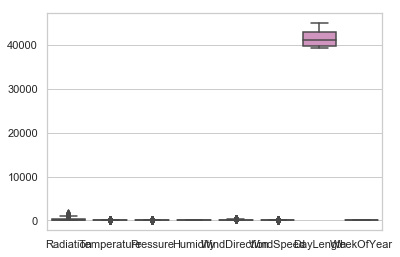

In [72]:
sns.set(style="whitegrid", color_codes=True)
sns.boxplot(data=df);

In [ ]:
# Podemos identificar que dentre os dados mais importantes, a Radiação possui muitos dados que fogem do padrão, o que
# pode ser visualizado nas analises abaixo:

In [73]:
# Primeiramente obtive a média da Radiação
np.mean(df.Radiation, axis=0)

207.12469742399355

In [74]:
rad = df['Radiation'].as_matrix()
print(rad)

[2.58 2.83 2.16 ... 1.21 1.19 1.21]


C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


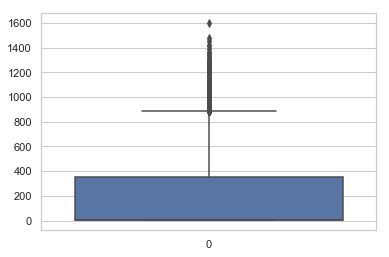

In [75]:
# Fazendo uma análise mais profunda dos dados de radiação vemos que existem muitos outliers.
sns.set(style="whitegrid", color_codes=True)
sns.boxplot(data=rad);

In [41]:
media = np.mean(rad, axis=0)
dp = np.std(rad, axis=0)

In [ ]:
# Para começar armazenamos os valores da média e desvio padrão e calculamos o limite inferior e superior com os 
# códigos abaixo.

In [42]:
media - 2 * dp

-424.69841170272343

In [43]:
media + 2 * dp

838.9478065506705

In [77]:
# A grande questão quando se identifica os outliers é o que se fazer com eles. Pode ser feito três coisas:
# - Fazer nada
# - Remover os registros
# - Corrigilos
# Ao Fazer nada e Remover o registro acabamos por deixar nossos dados mais sujos, há quem diga que nao devemos fazer
# nada quando encontramos outliers pois iremos interferir nos dados, e os removendo iria alterar os dados ainda mais.
# Sendo assim decidi somente corrigilos.

In [ ]:
# A correção foi feita identificando os outliers e os substituindo pela média encontrada dos dados de Radiação.

# Com os limites definidos, podemos obter os dados que estão fora desses limites, para assim então substitui-los.

In [45]:
# Verificação do limite Inferior
for x in rad:
    if(x < media - 2 * dp):
        print(x)

In [ ]:
# Era esperado que não tivesse nehum outlier para o limeite inferior.

In [46]:
# Verificação do limite Superioro
for x in rad:
    if(x > media + 2 * dp):
        print(x)

899.06
928.27
999.94
916.47
986.69
1073.71
1027.63
1006.1
1012.53
1008.46
1013.32
1009.88
978.36
952.03
974.1
1005.43
1000.96
1063.06
1061.27
1065.3
1070.12
1067.15
1072.24
1072.94
1073.43
1069.16
1059.15
1051.8
1058.61
1048.67
1039.12
1019.48
1018.59
998.96
1004.49
989.02
978.9
972.4
948.24
942.14
926.05
918.24
902.24
884.62
877.7
866.92
856.11
843.89
846.58
857.95
872.22
885.18
896.17
910.18
922.19
930.87
943.48
953.14
963.72
972.88
981.26
990.46
994.46
1005.39
1013.88
1019.04
1026.27
1031.01
1039.6
1042.62
1046.7
1050.79
1054.54
1055.61
1057.91
1058.03
1059.3
1060.85
1062.01
1059.37
1059.79
1058.82
1054.84
1052.69
1048.63
1027.13
1043.28
1037.8
1029.84
1031.59
1024.83
1018.05
1011.23
999.87
993.41
988.77
978.68
966.7
955.95
943.36
931.96
909.25
895.73
879.59
873.71
904.94
939.55
840.74
913.08
854.21
938.35
1088.09
865.52
850.5
1368.35
1207.12
1475.4
1601.26
1265.47
988.64
843.56
859.81
872.42
884.26
899.71
911.03
926.04
949.43
956.43
966.72
979.73
991.02
996.12
1005.56
1012.25
1020.

884.64
887.26
881.74
880.94
878.49
880.85
874.68
867.34
854.96
847.18
862.7
855.8
849.5
844.55
843.06
842.85
842.23
851.17
856.63
842.96
851.34
857.51
865.94
873.18
875.77
882.58
885.69
890.52
893.72
898.84
897.88
902.74
895.63
895.02
892.11
895.28
893.78
899.23
899.08
898.42
946.11
938.67
912.97
953.59
890.22
929.56
929.85
961.94
848.47
885.68
881.41
841.69
850.78
857.95
860.8
867.61
874.13
880.39
885.6
886.7
889.87
889.81
893.86
896.89
895.59
897.64
895.54
892.96
898.72
888.22
891.36
882.71
875.9
874.25
870.88
867.94
864.85
859.69
846.66
849.25
840.16
841.02
847.28
855.99
862.78
869.48
874.3
880.84
883.45
888.38
893.04
894.95
899.49
899.18
901.07
903.65
902.39
902.83
903.76
903.21
898.76
895.55
895.75
889.59
890.44
884.83
881.08
871.92
868.11
861.46
855.84
844.06
839.57
841.14
848.71
857.81
865.92
870.45
878.52
884.03
887.35
891.55
893.82
901.84
904.35
905.46
908.99
908.54
910.08
911.27
908.91
909.22
908.7
904.91
905.63
902.1
899.16
895.0
891.26
885.42
880.11
873.87
864.93
859.3
854.

In [49]:
# Acima os outliers encontrados e abaixo a função de correção:
med = media + 2 * dp
df.loc[df.Radiation > med, 'Radiation'] = np.nan
df.fillna(med,inplace=True)

In [ ]:
# Plorando novamente o grafico podemos observar que os outliers sumiram.

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


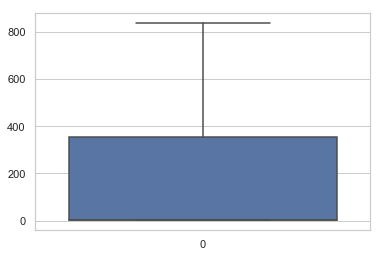

In [50]:
rad = df['Radiation'].as_matrix()

sns.set(style="whitegrid", color_codes=True)
sns.boxplot(data=rad);

In [ ]:
# Com isso observamos como identificar e tratar os outliers dos dados.